In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("/content/Exam_Score_Prediction.csv")

In [3]:
data.shape

(20000, 13)

In [4]:
data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

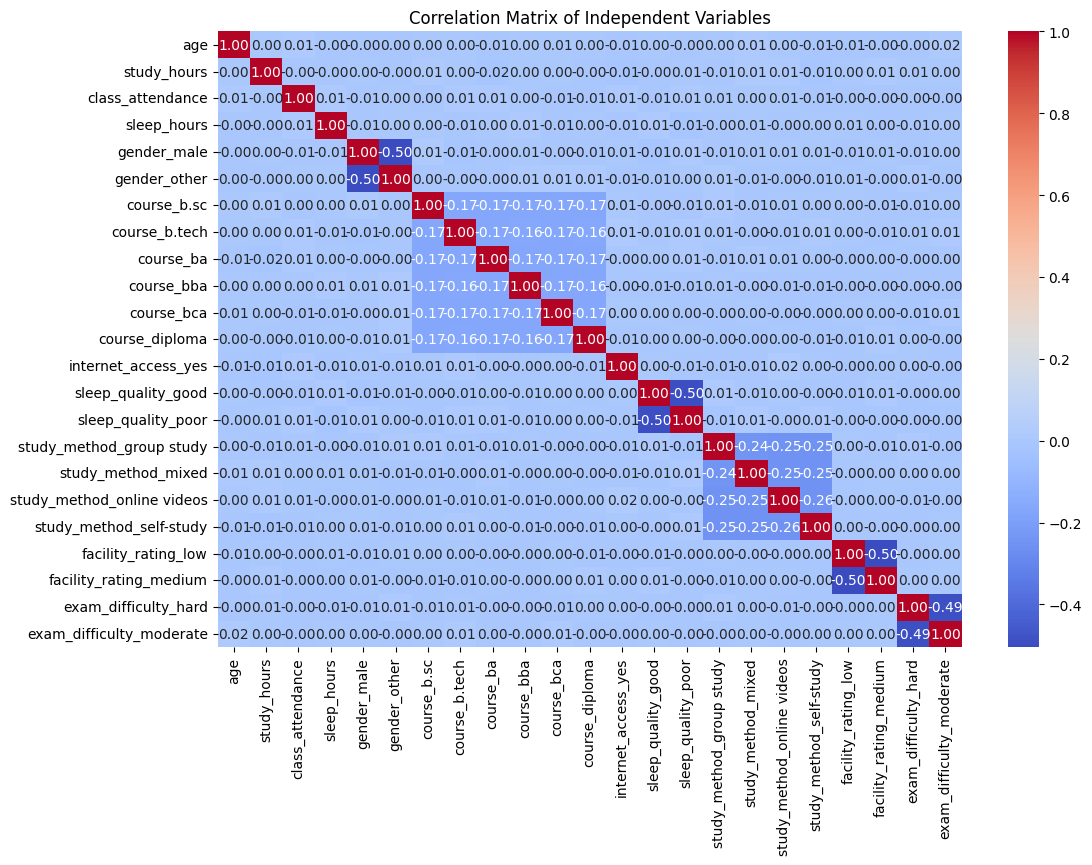

                       feature       VIF
11                  course_bca  1.722205
9                    course_ba  1.720921
7                  course_b.sc  1.718045
10                  course_bba  1.709301
12              course_diploma  1.707037
8                course_b.tech  1.702327
19     study_method_self-study  1.601815
18  study_method_online videos  1.600724
16    study_method_group study  1.586046
17          study_method_mixed  1.583229
5                  gender_male  1.344261
6                 gender_other  1.343892
21      facility_rating_medium  1.340781
20         facility_rating_low  1.340484
14          sleep_quality_good  1.331591
15          sleep_quality_poor  1.331567
23    exam_difficulty_moderate  1.321322
22        exam_difficulty_hard  1.321097
2                  study_hours  1.001245
13         internet_access_yes  1.001127
4                  sleep_hours  1.000901
1                          age  1.000824
3             class_attendance  1.000803


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

features = data.drop(columns=['student_id', 'exam_score'])
features_encoded = pd.get_dummies(features, drop_first=True)
plt.figure(figsize=(12, 8))
correlation_matrix = features_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Independent Variables")
plt.show()
X = add_constant(features_encoded.astype(float))

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_results = vif_data[vif_data['feature'] != 'const'].sort_values(by="VIF", ascending=False)
print(vif_results)

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(columns=['student_id', 'exam_score'])
y = data['exam_score']

# Step 2: Train-Test Split (Crucial for avoiding leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Identify Column Types
numerical_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
categorical_cols = ['gender', 'course', 'internet_access', 'sleep_quality',
                    'study_method', 'facility_rating', 'exam_difficulty']

# Step 4: Create Preprocessing Pipelines
# We use ColumnTransformer to ensure transformations are applied correctly
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Centers and scales numerical data
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' helps reduce multicollinearity
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 5: Define the Model Pipeline
# This ensures that the preprocessing is fitted ONLY on the training fold during cross-validation
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 6: Fit the Model
model_pipeline.fit(X_train, y_train)

# Step 7: Evaluate without Leakage
y_pred = model_pipeline.predict(X_test)

print(f"R-squared Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Step 8: Inspect Coefficients (To see feature importance)
feature_names = (numerical_cols +
                 list(model_pipeline.named_steps['preprocessor']
                      .transformers_[1][1].named_steps['onehot']
                      .get_feature_names_out(categorical_cols)))

coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': model_pipeline.named_steps['regressor'].coef_})
print("\nTop Predictors:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

R-squared Score: 0.7330
RMSE: 9.7725

Top Predictors:
                       Feature  Coefficient
1                  study_hours    13.569750
2             class_attendance     5.945520
13          sleep_quality_good     4.543658
3                  sleep_hours     2.490941
22    exam_difficulty_moderate     0.230131
5                 gender_other     0.199022
7                course_b.tech     0.166206
21        exam_difficulty_hard     0.114154
10                  course_bca     0.111993
8                    course_ba     0.094280
12         internet_access_yes     0.080466
11              course_diploma     0.055550
4                  gender_male     0.046562
9                   course_bba    -0.004206
0                          age    -0.018572
6                  course_b.sc    -0.208375
20      facility_rating_medium    -3.801692
14          sleep_quality_poor    -4.789733
16          study_method_mixed    -4.973947
15    study_method_group study    -7.776208
19         facility_ra

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Define the XGBoost Model within the existing pipeline structure
# We use hyperparameter values that are generally good starting points
xgb_model = XGBRegressor(
    n_estimators=1000,    # Number of boosting rounds
    learning_rate=0.05,   # Step size shrinkage to prevent overfitting
    max_depth=6,          # Depth of the trees
    subsample=0.8,        # Use 80% of data to train each tree
    colsample_bytree=0.8, # Use 80% of features for each tree
    n_jobs=-1,            # Use all available CPU cores
    random_state=42
)

# 2. Re-create the Pipeline using your previous 'preprocessor'
# This ensures scaling and encoding are applied without leakage
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# 3. Fit the Model
# Note: XGBoost can use an 'evaluation set' to stop early if the score stops improving
xgb_pipeline.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R-squared Score: {xgb_r2:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

XGBoost R-squared Score: 0.7066
XGBoost RMSE: 10.2441


In [17]:
from sklearn.linear_model import RidgeCV, LassoCV

# 1. Define the Ridge Pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

# 2. Define the Lasso Pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42))
])

# 3. Fit and Evaluate Ridge
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
print(f"Ridge R-squared: {r2_score(y_test, y_pred_ridge):.4f}")

# 4. Fit and Evaluate Lasso
lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
print(f"Lasso R-squared: {r2_score(y_test, y_pred_lasso):.4f}")

# 5. Check Lasso Feature Selection
# Let's see which features Lasso kept (non-zero)
lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_
selected_features = [f for f, c in zip(feature_names, lasso_coefs) if c != 0]
print(f"\nLasso kept {len(selected_features)} out of {len(feature_names)} features.")

Ridge R-squared: 0.7330
Lasso R-squared: 0.7332

Lasso kept 16 out of 23 features.


In [18]:
# Create a copy to avoid SettingWithCopy warnings
df_eng = data.copy()

# 1. Sleep Quality Mapping (Categorical to Numeric)
quality_map = {'good': 3, 'average': 2, 'poor': 1}
df_eng['sleep_score'] = df_eng['sleep_quality'].str.lower().map(quality_map)

# 2. Construct New Interaction Features
df_eng['study_efficiency'] = df_eng['study_hours'] * df_eng['sleep_hours']
df_eng['total_engagement'] = df_eng['study_hours'] * df_eng['class_attendance']
df_eng['rest_quality_index'] = df_eng['sleep_hours'] * df_eng['sleep_score']

# 3. Drop original columns to avoid Multicollinearity
# We drop the parents of the interactions to keep the model clean
cols_to_drop = ['study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality', 'student_id']
X_new = df_eng.drop(columns=cols_to_drop + ['exam_score'])
y = df_eng['exam_score']

# Re-split and test
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Update categorical and numerical lists for X_new
new_num_cols = ['age', 'study_efficiency', 'total_engagement', 'rest_quality_index', 'sleep_score']
new_cat_cols = [c for c in X_new.columns if c not in new_num_cols]

# Re-define the preprocessor for the new column set
preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), new_cat_cols)
    ])

# Dictionary to store results
results = {}

models = {
    "Baseline LR": LinearRegression(),
    "Ridge (L2)": RidgeCV(alphas=np.logspace(-6, 6, 13)),
    "Lasso (L1)": LassoCV(cv=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
}

for name, model in models.items():
    # Create pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor_new), ('regressor', model)])

    # Fit and Predict
    pipe.fit(X_train_n, y_train_n)
    preds = pipe.predict(X_test_n)

    # Metrics
    r2 = r2_score(y_test_n, preds)
    rmse = np.sqrt(mean_squared_error(y_test_n, preds))
    results[name] = {"R2": r2, "RMSE": rmse}

# Display Results
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R2', ascending=False))

                   R2       RMSE
XGBoost      0.713296  10.126861
Lasso (L1)   0.708220  10.216107
Ridge (L2)   0.707955  10.220737
Baseline LR  0.707949  10.220843
